# Tutorial: Transformers, Vision Transformers and applications

**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/metrics-lab/transformer-tutorial/blob/main/tutorial/transformers_tutorial.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/metrics-lab/transformer-tutorial/blob/main/tutorial/transformer_tutorial_aml.ipynb)  
**Pre-trained models:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/github/metrics-lab/transformer-tutorial/blob/main/saved_models/)

**Author:** Simon Dahan

**Contact:** Please contact me at simon.dahan@kcl.ac.uk if you have questions on the tutorial or want to discuss some concepts further.





# Tutorial overview


<b>Part 1: Surface Vision Transformers</b></summary>

<b>Part 2: The Multiscale Surface Vision Transformers</b></summary>

<b>Part 3: Loading pre-trained models</b></summary>


# Import

In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
import yaml

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data/dhcp"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = False #True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_3167692/2084361262.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


CUDA available: True
CUDA version: 11.8
GPU count: 2
Current device: 0
Device name: NVIDIA GeForce RTX 3090
Device: cuda:0


<Figure size 640x480 with 0 Axes>

# 1. Surface Vision Transformers


In this last part of the tutorial, we will investigate extension of the Vision Transformer to non-Euclidean geometries. As you probably already understood, the transformer achitecture can be used in many different data domains. We often describe the transformer architecture as *agnostic* to the domain, as long as the input data can be represented as a sequence of tokens. [Dahan et al 2022](https://arxiv.org/abs/2203.16414) extented the vision transformer architecture to study cortical surfaces represented on regular icosehadron. This is achivied by patching sphericalised meshes using low resolution icospheral grids and then using a regular ViT to process the cortical patches. The model is named Surface Vision Trasnformer (SiT).

<center width="100%"><img src="https://github.com/metrics-lab/transformer-tutorial/blob/main/tutorial/sit_gif.gif?raw=1"  width="800px"></center>

First let's clone the code for the SiT model and install some necessary dependencies

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from models.sit import SiT
from models.ms_sit_shifted import MSSiT_shifted

/home/sd20/anaconda3/envs/tuto/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1 dHCP dataset

Here you will be downloading data from the dHCP dataset. The data has already been processed in order to use the SiT out-of-the-box. Four cortical metrics (myelin maps, cortical thickness, sulcal depth, curvature) are used and ico6 sphericalised meshes are patched using a ico2 sphericalised grid. This leads to a sequence of 320 non-overlapping patching of 153 vertices each (see illustration).

We will use data from the scan age experiment as per [A. Fawaz et al 2021](https://www.biorxiv.org/content/10.1101/2021.12.01.470730v1.full.pdf).

In [8]:
import gdown
!gdown https://drive.google.com/uc?id=1DJhrERb1hk8Ekp_Cq2qwnxYvjq2nM0kc # Download the pre-trained model google drive

!unzip -q ./dhcp_scan_age_template_processed.zip -d ../data/dhcp_ico2/ 

Downloading...
From (original): https://drive.google.com/uc?id=1DJhrERb1hk8Ekp_Cq2qwnxYvjq2nM0kc
From (redirected): https://drive.google.com/uc?id=1DJhrERb1hk8Ekp_Cq2qwnxYvjq2nM0kc&confirm=t&uuid=2df4c5fa-a678-4fc1-add3-073942255969
To: /home/sd20/workspace/github/metrics-lab/surface-deep-learning-tutorial/scripts/dhcp_scan_age_template_processed.zip
100%|████████████████████████████████████████| 731M/731M [00:08<00:00, 85.6MB/s]


In [3]:
train_data = np.load('../data/dhcp_ico2/train_data.npy')
validation_data = np.load('../data/dhcp_ico2/validation_data.npy')

train_labels = np.load('../data/dhcp_ico2/train_labels.npy')
validation_labels = np.load('../data/dhcp_ico2/validation_labels.npy')

print(train_data.shape, validation_data.shape, train_labels.shape, validation_labels.shape)

(846, 4, 320, 153) (106, 4, 320, 153) (846,) (106,)


In [4]:
batch_size = 32

train_data_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float(),
                                                    torch.from_numpy(train_labels).float())

train_loader = torch.utils.data.DataLoader(train_data_dataset,
                                                batch_size = batch_size,
                                                shuffle=True,
                                                num_workers=16)

val_data_dataset = torch.utils.data.TensorDataset(torch.from_numpy(validation_data).float(),
                                                torch.from_numpy(validation_labels).float())


val_loader = torch.utils.data.DataLoader(val_data_dataset,
                                        batch_size = batch_size,
                                        shuffle=False,
                                        num_workers=16)

In [5]:
path_to_config = '../config/SiT/hparams.yml'
with open(path_to_config) as f:
    config = yaml.safe_load(f)

ico_mesh = config['mesh_resolution']['ico_mesh']
ico_grid = config['mesh_resolution']['ico_grid']

## 1.2 SiT training - From scratch

We will train the model for task of scan age (PMA) prediction. This is a regressiont task. Therefore, we will use the MSELoss to evaluate the model and the Adam optimiser.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sit_model = SiT(dim=config['transformer']['dim'],
            depth=config['transformer']['depth'],
            heads=config['transformer']['heads'],
            pool='cls',
            num_patches=config['ico_{}_grid'.format(ico_grid)]['num_patches'],
            num_classes=config['transformer']['num_classes'],
            num_channels=len(config['transformer']['channels']),
            num_vertices=config['ico_{}_grid'.format(ico_grid)]['num_vertices'],
            dim_head=config['transformer']['dim_head'],
            dropout=config['transformer']['dropout'],
            emb_dropout=0.,
            bottleneck_dropout = 0.,
            mlp_ratio = 4,
            use_pe = 'sin-cos',
            use_confounds = False,
            use_bottleneck= False, 
            weights_layers_init = config['transformer']['init_weights_layers'],
            use_class_token=config['transformer']['use_class_token'],
            trainable_pos_emb=config['transformer']['trainable_pos_emb'],
            no_class_token_emb = config['transformer']['no_class_token_emb'],)

sit_model.to(device)

num_training_epochs=150
num_val_epochs=10
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(sit_model.parameters(), lr=0.0003, weight_decay=0.0)

Using Sin-Cos positional embeddings


In [7]:
best_mae = 100000000
mae_val_epoch = 100000000
running_val_loss = 100000000

sit_training_losses = []
sit_validation_losses = []
sit_training_errors = []
sit_validation_errors = []
sit_train_epochs = []
sit_val_epochs = []


for epoch in range(num_training_epochs):

    running_loss = 0

    sit_model.train()

    targets_ =  []
    preds_ = []

    for i, data in enumerate(train_loader):

        inputs, targets = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = sit_model(inputs)

        loss = criterion(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        targets_.append(targets.cpu().numpy())
        preds_.append(outputs.reshape(-1).cpu().detach().numpy())

    mae_epoch = np.mean(np.abs(np.concatenate(targets_) - np.concatenate(preds_)))
    sit_training_losses.append(running_loss/(i+1))
    sit_training_errors.append(mae_epoch)
    sit_train_epochs.append(epoch+1)
    training_loss_epoch = running_loss/(i+1)

    if (epoch+1)%1==0:
        print('| Epoch - {} | Loss - {:.4f} | MAE - {:.4f} | LR - {}'.format(epoch+1, running_loss/(i+1), round(mae_epoch,4), optimizer.param_groups[0]['lr']))

    ##############################
    ######    VALIDATION    ######
    ##############################

    if (epoch+1)%num_val_epochs==0:

        running_val_loss = 0

        sit_model.eval()

        with torch.no_grad():

            targets_ = []
            preds_ = []

            for i, data in enumerate(val_loader):

                inputs, targets = data[0].to(device), data[1].to(device)

                outputs = sit_model(inputs)

                loss = criterion(outputs.squeeze(), targets)

                running_val_loss += loss.item()

                targets_.append(targets.cpu().numpy())
                preds_.append(outputs.reshape(-1).cpu().numpy())


        mae_val_epoch = np.mean(np.abs(np.concatenate(targets_)- np.concatenate(preds_)))
        sit_validation_losses.append(running_val_loss/(i+1))
        sit_validation_errors.append(mae_val_epoch)
        sit_val_epochs.append(epoch+1)

        print('| Validation | Epoch - {} | Loss - {:.4f} | MAE - {:.4f} |'.format(epoch+1, running_val_loss/(i+1), mae_val_epoch ))

        if mae_val_epoch < best_mae:
            best_mae = mae_val_epoch
            best_epoch = epoch+1

            df = pd.DataFrame()
            df['preds'] = np.concatenate(preds_).reshape(-1)
            df['targets'] = np.concatenate(targets_).reshape(-1)
            df.to_csv(os.path.join(CHECKPOINT_PATH, 'preds_test.csv'))

            os.makedirs(os.path.join(CHECKPOINT_PATH,'log/sit'), exist_ok=True)

            torch.save({'epoch': epoch,
                       'model_state_dict':sit_model.state_dict(),
                       'optimizer_state_dict': optimizer.state_dict(),
                       'loss': training_loss_epoch,
                        },
                        os.path.join(CHECKPOINT_PATH,'logs/sit/checkpoint.pth'))


print('Final results: best model obtained at epoch {} - mean absolute error in weeks {}'.format(best_epoch,best_mae))


| Epoch - 1 | Loss - 1008.3928 | MAE - 31.5615 | LR - 0.0003
| Epoch - 2 | Loss - 884.5543 | MAE - 29.5863 | LR - 0.0003
| Epoch - 3 | Loss - 792.3864 | MAE - 27.9843 | LR - 0.0003
| Epoch - 4 | Loss - 700.1885 | MAE - 26.2939 | LR - 0.0003
| Epoch - 5 | Loss - 612.2617 | MAE - 24.5302 | LR - 0.0003
| Epoch - 6 | Loss - 526.7838 | MAE - 22.7125 | LR - 0.0003
| Epoch - 7 | Loss - 446.3512 | MAE - 20.8641 | LR - 0.0003
| Epoch - 8 | Loss - 372.1553 | MAE - 19.0103 | LR - 0.0003
| Epoch - 9 | Loss - 304.6939 | MAE - 17.1668 | LR - 0.0003
| Epoch - 10 | Loss - 245.9392 | MAE - 15.3738 | LR - 0.0003
| Validation | Epoch - 10 | Loss - 186.8304 | MAE - 14.0739 |
| Epoch - 11 | Loss - 196.8141 | MAE - 13.6392 | LR - 0.0003
| Epoch - 12 | Loss - 154.3681 | MAE - 11.9775 | LR - 0.0003
| Epoch - 13 | Loss - 118.4970 | MAE - 10.4233 | LR - 0.0003
| Epoch - 14 | Loss - 90.7145 | MAE - 8.9826 | LR - 0.0003
| Epoch - 15 | Loss - 68.8630 | MAE - 7.6903 | LR - 0.0003
| Epoch - 16 | Loss - 51.4131 | MAE

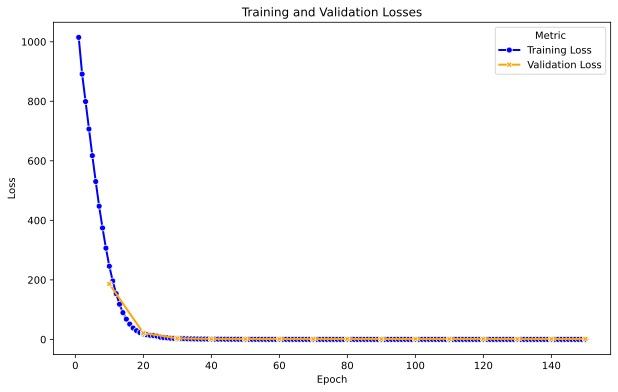

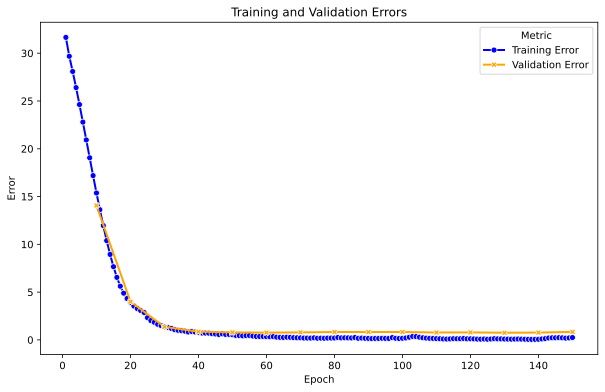

In [14]:

# Create a DataFrame
data = pd.DataFrame({
    'Epoch': sit_train_epochs + sit_val_epochs+ sit_train_epochs + sit_val_epochs,
    'Value': sit_training_losses + sit_validation_losses + sit_training_errors + sit_validation_errors,
    'Type': ['Training Loss'] * len(sit_training_losses) + ['Validation Loss'] * len(sit_validation_losses) +
            ['Training Error'] * len(sit_training_errors) + ['Validation Error'] * len(sit_validation_errors)
})

# Plot training and validation losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=data[data['Type'].isin(['Training Loss', 'Validation Loss'])],
             x='Epoch', y='Value', hue='Type', palette=['blue', 'orange'], style='Type', markers=True, dashes=False)
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Metric')
plt.show()

# Plot training and validation errors
plt.figure(figsize=(10, 6))
sns.lineplot(data=data[data['Type'].isin(['Training Error', 'Validation Error'])],
             x='Epoch', y='Value', hue='Type', palette=['blue', 'orange'], style='Type', markers=True, dashes=False)
plt.title('Training and Validation Errors')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(title='Metric')
plt.show()

In [15]:
del sit_model

## 2. MS-SiT training - From scratch

<center width="100%"><img src=./ms_sit.jpg width="800px"></center>


For MS-SiT we use here a subset of the preprocessed dHCP data, as the preprocessed dataset with ico5 patching is about ~6G.

In [20]:
import gdown
!gdown https://drive.google.com/uc?id=13lcwipO91ZSfLEDdaSKg15PNdG8o4GJK # Download the pre-trained model google drive

!unzip -q ./dhcp_scan_age_template_processed_ico5.zip -d ../data/dhcp_ico5/ 

Downloading...
From (original): https://drive.google.com/uc?id=13lcwipO91ZSfLEDdaSKg15PNdG8o4GJK
From (redirected): https://drive.google.com/uc?id=13lcwipO91ZSfLEDdaSKg15PNdG8o4GJK&confirm=t&uuid=9448c26b-d38e-4c6d-ad0f-38f7a26e6a41
To: /home/sd20/workspace/github/metrics-lab/surface-deep-learning-tutorial/scripts/dhcp_scan_age_template_processed_ico5.zip
100%|████████████████████████████████████████| 402M/402M [00:04<00:00, 81.0MB/s]


In [21]:
train_data = np.load('../data/dhcp_ico5/sub_train_data_ico5.npy')
validation_data = np.load('../data/dhcp_ico5/sub_val_data_ico5.npy')

train_labels = np.load('../data/dhcp_ico5/sub_train_labels_ico5.npy')
validation_labels = np.load('../data/dhcp_ico5/sub_val_labels_ico5.npy')

print(train_data.shape, validation_data.shape, train_labels.shape, validation_labels.shape)

(280, 4, 20480, 6) (40, 4, 20480, 6) (280,) (40,)


In [31]:
batch_size = 24

train_data_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float(),
                                                    torch.from_numpy(train_labels).float())

train_loader = torch.utils.data.DataLoader(train_data_dataset,
                                                batch_size = batch_size,
                                                shuffle=True,
                                                num_workers=16)

val_data_dataset = torch.utils.data.TensorDataset(torch.from_numpy(validation_data).float(),
                                                torch.from_numpy(validation_labels).float())


val_loader = torch.utils.data.DataLoader(val_data_dataset,
                                        batch_size = batch_size,
                                        shuffle=False,
                                        num_workers=16)

In [32]:
path_to_config = '../config/MS-SiT/hparams.yml'
with open(path_to_config) as f:
    config = yaml.safe_load(f)

ico_mesh = config['mesh_resolution']['ico_mesh']
ico_grid = config['mesh_resolution']['ico_grid']

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ms_sit_model = MSSiT_shifted(ico_init_resolution=config['mesh_resolution']['ico_grid'],
                                    num_channels=len(config['transformer']['channels']),
                                    num_classes=1,
                                    embed_dim=config['transformer']['dim'],
                                    depths=config['transformer']['depth'],
                                    num_heads=config['transformer']['heads'],
                                    window_size=config['transformer']['window_size'],
                                    window_size_factor=config['transformer']['window_size_factor'],
                                    mlp_ratio=4,
                                    qkv_bias=True,
                                    qk_scale=True,
                                    dropout=config['transformer']['dropout'],
                                    attention_dropout=config['transformer']['attention_dropout'],
                                    drop_path_rate=config['transformer']['drop_path_rate'],
                                    norm_layer=nn.LayerNorm,
                                    use_pos_emb=config['transformer']['use_pos_emb'],
                                    patch_norm=True,
                                    use_confounds=False,
                                    device=device)

ms_sit_model.to(device)

num_training_epochs=150
num_val_epochs=10
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(ms_sit_model.parameters(), lr=0.0003, weight_decay=0.0)

window size: [64, 64, 64, 320]
window size factor: 4
*** use global attention in the last stage**


In [34]:
best_mae = 100000000
mae_val_epoch = 100000000
running_val_loss = 100000000

ms_sit_training_losses = []
ms_sit_validation_losses = []
ms_sit_training_errors = []
ms_sit_validation_errors = []
ms_sit_train_epochs = []
ms_sit_val_epochs = []


for epoch in range(num_training_epochs):

    running_loss = 0

    ms_sit_model.train()

    targets_ =  []
    preds_ = []

    for i, data in enumerate(train_loader):

        inputs, targets = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = ms_sit_model(inputs)

        loss = criterion(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        targets_.append(targets.cpu().numpy())
        preds_.append(outputs.reshape(-1).cpu().detach().numpy())

    mae_epoch = np.mean(np.abs(np.concatenate(targets_) - np.concatenate(preds_)))
    ms_sit_training_losses.append(running_loss/(i+1))
    ms_sit_training_errors.append(mae_epoch)
    ms_sit_train_epochs.append(epoch+1)

    if (epoch+1)%1==0:
        print('| Epoch - {} | Loss - {:.4f} | MAE - {:.4f} | LR - {}'.format(epoch+1, running_loss/(i+1), round(mae_epoch,4), optimizer.param_groups[0]['lr']))

    ##############################
    ######    VALIDATION    ######
    ##############################

    if (epoch+1)%num_val_epochs==0:

        running_val_loss = 0

        ms_sit_model.eval()

        with torch.no_grad():

            targets_ = []
            preds_ = []

            for i, data in enumerate(val_loader):

                inputs, targets = data[0].to(device), data[1].to(device)

                outputs = ms_sit_model(inputs)

                loss = criterion(outputs.squeeze(), targets)

                running_val_loss += loss.item()

                targets_.append(targets.cpu().numpy())
                preds_.append(outputs.reshape(-1).cpu().numpy())


        mae_val_epoch = np.mean(np.abs(np.concatenate(targets_)- np.concatenate(preds_)))
        ms_sit_validation_losses.append(running_val_loss/(i+1))
        ms_sit_validation_errors.append(mae_val_epoch)
        ms_sit_val_epochs.append(epoch+1)

        print('| Validation | Epoch - {} | Loss - {:.4f} | MAE - {:.4f} |'.format(epoch+1, running_val_loss/(i+1), mae_val_epoch ))

        if mae_val_epoch < best_mae:
            best_mae = mae_val_epoch
            best_epoch = epoch+1

            df = pd.DataFrame()
            df['preds'] = np.concatenate(preds_).reshape(-1)
            df['targets'] = np.concatenate(targets_).reshape(-1)
            df.to_csv(os.path.join(CHECKPOINT_PATH, 'preds_test.csv'))

            os.makedirs(os.path.join(CHECKPOINT_PATH,'log/ms_sit'), exist_ok=True)

            torch.save(ms_sit_model.state_dict(), os.path.join(CHECKPOINT_PATH,'log/ms_sit/checkpoint.pth'))


print('Final results: best model obtained at epoch {} - mean absolute error in weeks {}'.format(best_epoch,best_mae))

| Epoch - 1 | Loss - 831.5358 | MAE - 28.4778 | LR - 0.0003
| Epoch - 2 | Loss - 568.4608 | MAE - 23.8132 | LR - 0.0003
| Epoch - 3 | Loss - 463.1194 | MAE - 21.4650 | LR - 0.0003
| Epoch - 4 | Loss - 367.2846 | MAE - 19.1085 | LR - 0.0003
| Epoch - 5 | Loss - 282.9341 | MAE - 16.7349 | LR - 0.0003
| Epoch - 6 | Loss - 210.0425 | MAE - 14.4118 | LR - 0.0003
| Epoch - 7 | Loss - 150.8198 | MAE - 12.1731 | LR - 0.0003
| Epoch - 8 | Loss - 103.9301 | MAE - 10.0622 | LR - 0.0003
| Epoch - 9 | Loss - 68.6737 | MAE - 8.1205 | LR - 0.0003
| Epoch - 10 | Loss - 43.5323 | MAE - 6.3993 | LR - 0.0003
| Validation | Epoch - 10 | Loss - 270.6057 | MAE - 8.5111 |
| Epoch - 11 | Loss - 26.6106 | MAE - 4.8940 | LR - 0.0003
| Epoch - 12 | Loss - 15.8155 | MAE - 3.6203 | LR - 0.0003
| Epoch - 13 | Loss - 9.3468 | MAE - 2.6696 | LR - 0.0003
| Epoch - 14 | Loss - 6.0043 | MAE - 2.0425 | LR - 0.0003
| Epoch - 15 | Loss - 4.1834 | MAE - 1.6583 | LR - 0.0003
| Epoch - 16 | Loss - 3.2941 | MAE - 1.4405 | LR -

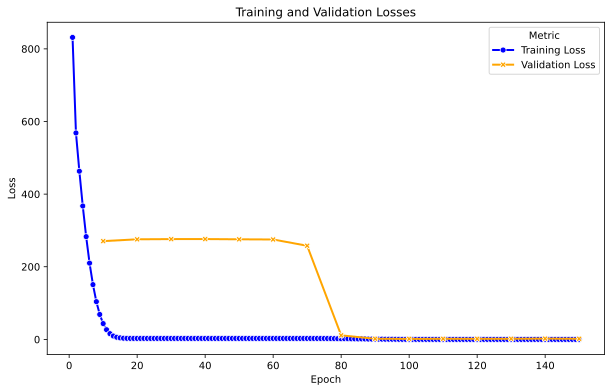

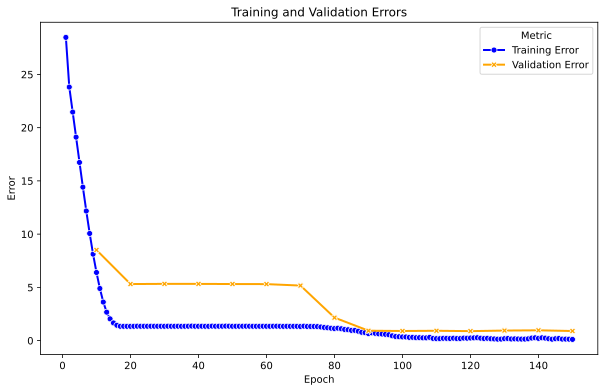

In [35]:
# Create a DataFrame
data = pd.DataFrame({
    'Epoch': ms_sit_train_epochs + ms_sit_val_epochs+ ms_sit_train_epochs + ms_sit_val_epochs,
    'Value': ms_sit_training_losses + ms_sit_validation_losses + ms_sit_training_errors + ms_sit_validation_errors,
    'Type': ['Training Loss'] * len(ms_sit_training_losses) + ['Validation Loss'] * len(ms_sit_validation_losses) +
            ['Training Error'] * len(ms_sit_training_errors) + ['Validation Error'] * len(ms_sit_validation_errors)
})

# Plot training and validation losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=data[data['Type'].isin(['Training Loss', 'Validation Loss'])],
             x='Epoch', y='Value', hue='Type', palette=['blue', 'orange'], style='Type', markers=True, dashes=False)
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Metric')
plt.show()

# Plot training and validation errors
plt.figure(figsize=(10, 6))
sns.lineplot(data=data[data['Type'].isin(['Training Error', 'Validation Error'])],
             x='Epoch', y='Value', hue='Type', palette=['blue', 'orange'], style='Type', markers=True, dashes=False)
plt.title('Training and Validation Errors')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(title='Metric')
plt.show()

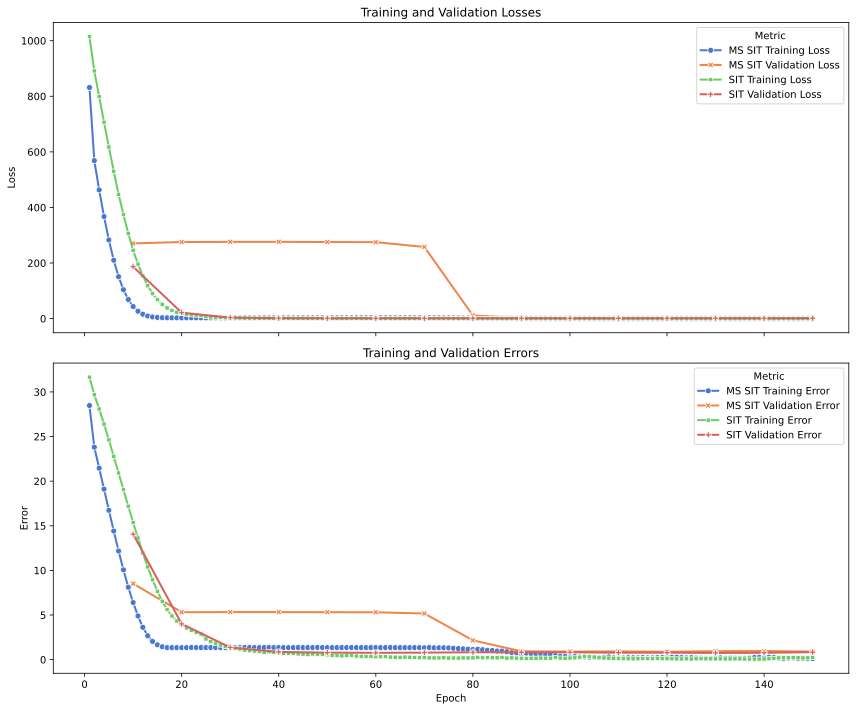

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the data from both sets
data = pd.DataFrame({
    'Epoch': ms_sit_train_epochs + ms_sit_val_epochs + ms_sit_train_epochs + ms_sit_val_epochs + 
             sit_train_epochs + sit_val_epochs + sit_train_epochs + sit_val_epochs,
    'Value': ms_sit_training_losses + ms_sit_validation_losses + ms_sit_training_errors + ms_sit_validation_errors + 
             sit_training_losses + sit_validation_losses + sit_training_errors + sit_validation_errors,
    'Type': ['MS SIT Training Loss'] * len(ms_sit_training_losses) + 
            ['MS SIT Validation Loss'] * len(ms_sit_validation_losses) +
            ['MS SIT Training Error'] * len(ms_sit_training_errors) + 
            ['MS SIT Validation Error'] * len(ms_sit_validation_errors) + 
            ['SIT Training Loss'] * len(sit_training_losses) + 
            ['SIT Validation Loss'] * len(sit_validation_losses) +
            ['SIT Training Error'] * len(sit_training_errors) + 
            ['SIT Validation Error'] * len(sit_validation_errors)
})

# Plot training and validation losses and errors using subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot training and validation losses
sns.lineplot(data=data[data['Type'].isin(['MS SIT Training Loss', 'MS SIT Validation Loss', 'SIT Training Loss', 'SIT Validation Loss'])],
             x='Epoch', y='Value', hue='Type', palette='muted', style='Type', markers=True, dashes=False, ax=axs[0])
axs[0].set_title('Training and Validation Losses')
axs[0].set_xlabel('')
axs[0].set_ylabel('Loss')
axs[0].legend(title='Metric')

# Plot training and validation errors
sns.lineplot(data=data[data['Type'].isin(['MS SIT Training Error', 'MS SIT Validation Error', 'SIT Training Error', 'SIT Validation Error'])],
             x='Epoch', y='Value', hue='Type', palette='muted', style='Type', markers=True, dashes=False, ax=axs[1])
axs[1].set_title('Training and Validation Errors')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Error')
axs[1].legend(title='Metric')

plt.tight_layout()
plt.show()


## 3. Loading Pre-trained models


In [8]:
path_to_config = '../config/SiT/hparams.yml'
with open(path_to_config) as f:
    config = yaml.safe_load(f)

ico_mesh = config['mesh_resolution']['ico_mesh']
ico_grid = config['mesh_resolution']['ico_grid']

In [9]:
sit_model = SiT(dim=config['transformer']['dim'],
            depth=config['transformer']['depth'],
            heads=config['transformer']['heads'],
            pool='cls',
            num_patches=config['ico_{}_grid'.format(ico_grid)]['num_patches'],
            num_classes=config['transformer']['num_classes'],
            num_channels=len(config['transformer']['channels']),
            num_vertices=config['ico_{}_grid'.format(ico_grid)]['num_vertices'],
            dim_head=config['transformer']['dim_head'],
            dropout=config['transformer']['dropout'],
            emb_dropout=0.,
            bottleneck_dropout = 0.,
            mlp_ratio = 4,
            use_pe = 'sin-cos',
            use_confounds = False,
            use_bottleneck= False, 
            weights_layers_init = config['transformer']['init_weights_layers'],
            use_class_token=config['transformer']['use_class_token'],
            trainable_pos_emb=config['transformer']['trainable_pos_emb'],
            no_class_token_emb = config['transformer']['no_class_token_emb'],)

Using Sin-Cos positional embeddings


In [10]:
path_to_ckpt = '../saved_models/logs/sit/checkpoint.pth'

checkpoint = torch.load(path_to_ckpt)
strict_loading = True
print('strict: {}'.format(strict_loading))

model_state_dict = sit_model.state_dict()
# Update only the matching keys and shapes
for name, param in checkpoint['model_state_dict'].items():
    if name in model_state_dict:
        if param.size() == model_state_dict[name].size():
            model_state_dict[name].copy_(param)
        else:
            print(f"Skipping {name} due to size mismatch: checkpoint {param.size()}, model {model_state_dict[name].size()}")

sit_model.load_state_dict(model_state_dict,strict=strict_loading)

strict: True


<All keys matched successfully>

# END OF THE TUTORIAL